classifiying multilabeled satellite images using the kaggle dataset <br>
also the first explicit intro to the datablock API, quite useful: refer docs and get familiar<br>
read article by Tom McKenzie

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [21]:
#!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


# getting the data

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#from google.colab import files
#files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rajp152k","key":"2f657177072627b976767f70ad0ae2fe"}'}

In [0]:
#!mkdir -p ~/.kaggle/
#!mv ./kaggle.json ~/.kaggle/kaggle.json

In [0]:
datapath = "/content/drive/My Drive/fast.ai v3/datasets/planet"

In [0]:
data_path = Path(datapath)

In [0]:
#!sudo apt install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [0]:
# !chmod 600 ~/.kaggle/kaggle.json

In [0]:
# ! kaggle competitions download -f 

In [0]:
# ! kaggle  competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p "./drive/My Drive/fast.ai v3/datasets/planet"  
# ! kaggle  competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p "./drive/My Drive/fast.ai v3/datasets/planet"  

train-jpg.tar.7z: Skipping, found more recently modified local copy (use --force to force download)
train_v2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
# ! unzip -q -n "./drive/My Drive/fast.ai v3/datasets/planet/train_v2.csv.zip" -d "./drive/My Drive/fast.ai v3/datasets/planet"

In [0]:
# ! 7za -bd -y -so x "./drive/My Drive/fast.ai v3/datasets/planet/train-jpg.tar.7z" | tar xf - -C "./drive/My Drive/fast.ai v3/datasets/planet"

# Multiclassification

using the datablock api <br>
refer docs for more info

In [0]:
df = pd.read_csv(data_path/'train_v2.csv')

In [26]:
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [35]:
df.tail()

,image_name,tags
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road
40478,train_40478,agriculture cultivation partly_cloudy primary


using the data block api to put this into a data bunch

In [0]:
get_transforms??

In [0]:
tfms = get_transforms(flip_vert=True,max_lighting = 0.1,max_zoom = 1.05,max_warp = 0.)

In [0]:
DataBunch??

In [0]:
# src =   (ImageList.from_csv(data_path,'train_v2.csv',folder = 'train-jpg',suffix = '.jpg')
#         .split_by_rand_pct(0.2)
#         .label_from_df(label_delim=' '))

In [0]:
# data = (src.transform(tfms,size=128)
#         .databunch()
#         .normalize(imagenet_stats))

In [0]:
data = (ImageList.from_csv(data_path,'train_v2.csv',folder='train-jpg',suffix='.jpg').
        split_by_rand_pct().
        label_from_df(label_delim=" ").
        transform(tfms,size=128).
        databunch().
        normalize(imagenet_stats))

In [0]:
data.sanity_check()

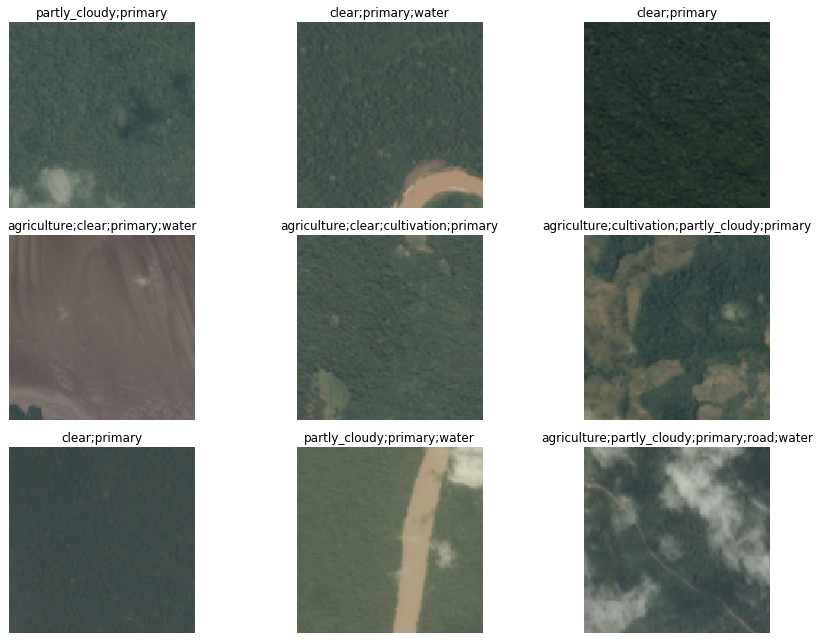

In [71]:
data.show_batch(rows=3,figsize=(12,9))

In [0]:
arch_ure = models.resnet50

using partial functions<br>
for metrics used in this kaggle competition

In [73]:
acc_02 = partial(accuracy_thresh,thresh=0.2)
f_score = partial(fbeta,thresh=0.2)
learn = cnn_learner(data,arch_ure,metrics = [acc_02,f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 53.6MB/s]


f_score is used as a combined metric to monitor precision and recall at the same time

finding a good learning rate:

In [74]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


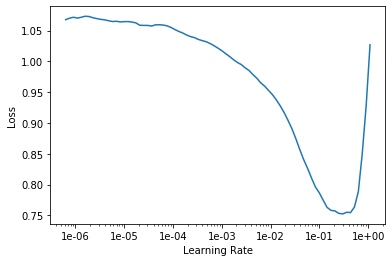

In [75]:
learn.recorder.plot()

In [0]:
lr = 6e-2

In [79]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.160120,0.158670,0.922095,0.871382,04:21
1,0.175608,0.888856,0.842059,0.772601,04:21
2,0.143831,0.193289,0.949787,0.892329,04:20
3,0.112013,5.813280,0.940305,0.905628,04:20
4,0.095200,0.870451,0.955688,0.920150,04:20


In [78]:
doc(learn.fit_one_cycle)

In [0]:
learn.save('stage-1-rn50')

fine-tuning

In [0]:
learn.unfreeze()

In [82]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


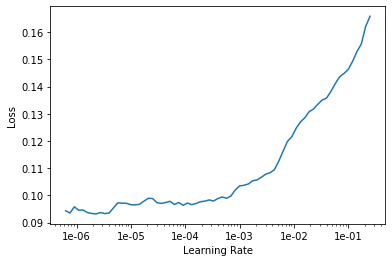

In [84]:
learn.recorder.plot()

choosing an lr corresponding to the first descent before the loss explosion :<br>
around 5e-5<br>
and an appropriate upper cap of around 1e-2

In [85]:
learn.fit_one_cycle(5,slice(1e-5,1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.102259,0.555955,0.950376,0.914870,04:28
1,0.106316,0.272293,0.950659,0.916314,04:30
2,0.099892,0.157549,0.954794,0.914972,04:30
3,0.094210,0.386945,0.956117,0.923406,04:31
4,0.088457,0.146151,0.956996,0.923099,04:29


In [0]:
learn.save('stage-2-rn50 size:(128)')

using images of size 256 now for improved accuracy<br>
using the same model as basis (small instance of transfer learning)<br>
not retraining from scratch

creating a new databunch of size 256 images

In [0]:
data = (ImageList.from_csv(data_path,'train_v2.csv',folder='train-jpg',suffix='.jpg').
        split_by_rand_pct().#0.2 by default
        label_from_df(label_delim=" ").
        transform(tfms,size=256).
        databunch().
        normalize(imagenet_stats))

In [93]:
learn.data=data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze() 
# first finding the working of current model on size 256 images 
# later unfreezing after using lr_find to update the model slightly
# (transfer learning)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


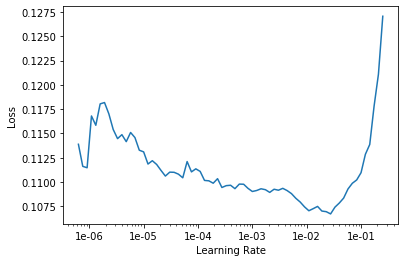

In [96]:
learn.lr_find()
learn.recorder.plot()

In [97]:
learn.fit_one_cycle(5,slice(1e-5,1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.103535,0.119574,0.955136,0.913307,06:09
1,0.095907,0.136617,0.959699,0.920524,06:11
2,0.097460,0.138784,0.959212,0.923398,06:11
3,0.093917,0.510323,0.954910,0.920379,06:12
4,0.088403,0.137621,0.955833,0.923989,06:13


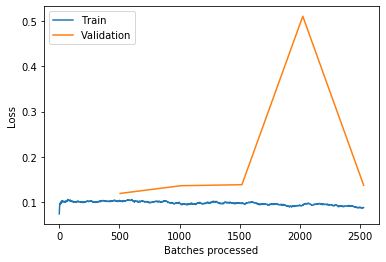

In [98]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

In [0]:
learn.export()

In [101]:
help(learn.export)

Help on method export in module fastai.basic_train:

export(file:Union[pathlib.Path, str, _io.BufferedWriter, _io.BytesIO]='export.pkl', destroy=False) method of fastai.basic_train.Learner instance
    Export the state of the `Learner` in `self.path/file`. `file` can be file-like (file or buffer)

